## DQN code

In [3]:

import torch
import torch.nn as nn
import copy
from tqdm import trange
import gymnasium as gym
from collections import deque, namedtuple
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import os
import json
from datetime import datetime
import pickle  # In order to save the buffer
import numpy as np
import copy
import matplotlib.colors as colors

''' GLOBALS'''
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])



class MyNetwork(nn.Module):
    # Create a feedforward neural network. Class contains two functions:
    # init is used for setting architecture of the neural network
    # forward is used for calculating output of the nn given an input

    def __init__(self, input_size, output_size):
        super().__init__() # What is this for? inherrent values from parrent class.
        nr_nodes = 60
        # Create input layer with ReLU activation
        self.input_layer = nn.Linear(input_size,nr_nodes)
        self.input_layer_activation = nn.ReLU(self.input_layer)

        # Create hidden layer(s) with ReLU activation
        self.hidden_layer1 = nn.Linear(nr_nodes, nr_nodes)
        self.hidden_layer_activation1 = nn.ReLU(self.hidden_layer1)

        self.hidden_layer2 = nn.Linear(nr_nodes, output_size)
        self.hidden_layer_activation2 = nn.ReLU(self.hidden_layer2)
        # Create output layer
        self.output_layer = nn.Linear(output_size,output_size)

    def forward(self, input_x):
        # Function used to compute the forward pass
        # Compute output of the first layer
        connection = self.input_layer_activation(input_x)
        # Compute output of the hidden layer
        input_x = self.hidden_layer_activation1(connection)
        input_x = self.hidden_layer_activation2(connection)
        # Compute output of the output layer
        output_y = self.output_layer(connection)

        return output_y

class ExperienceReplayBuffer(object):
    """ Class used to store a buffer containing experiences of the RL agent.
    """

    def __init__(self, capacity):
        # Create buffer of maximum length using deque function (check documentation)
        self.buffer = deque(maxlen=capacity)

    def append(self, experience):
        # Append experience to the buffer
        self.buffer.append(experience)

    def sample_batch(self, batch_size):
        """ Function used to sample experiences from the buffer.
            returns 5 lists, each of size n. Returns a list of state, actions,
            rewards, next states and done variables.
        """
        # If we try to sample more elements that what are available from the buffer we raise an error
        if batch_size > len(self.buffer):
            raise MemoryError('Requested more data than what is available from the buffer!')

        # Sample without replacement the indices of the experiences
        # np.random.choice takes 3 parameters: number of elements of the buffer, number of elements to sample and replacement
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)

        # Using the indices that we just sampled build a list of chosen experiences
        batch = [self.buffer[x] for x in indices]

        # batch is a list of size n, where each element is an Experience tuple of 5 elements.
        # To convert a list of tuples into a tuple of list we do zip(*batch).
        # In this case this will return a tuple of 5 elements where each element is a list of n elements.
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert elements to tensors - use torch.tensor
        states = torch.tensor(states, requires_grad=False)
        actions = torch.tensor(np.array(actions), dtype=torch.int64, requires_grad=False)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, requires_grad=False)
        next_states = torch.tensor(np.array(next_states), requires_grad=False)
        dones = torch.tensor(dones, dtype=torch.uint8, requires_grad=False)

        return states, actions, rewards, next_states, dones


class Agent(object):
    ''' Base agent class, used as a parent class

        Args:
            n_actions (int): number of actions

        Attributes:
            n_actions (int): where we store the number of actions
            last_action (int): last action taken by the agent
    '''

    def __init__(self, n_actions: int):
        self.n_actions = n_actions
        self.last_action = None

    def forward(self, state: np.ndarray):
        ''' Performs a forward computation '''
        pass

    def backward(self):
        ''' Performs a backward pass on the network '''
        pass


class RandomAgent(Agent):
    ''' Agent taking actions uniformly at random, child of the class Agent'''

    def __init__(self, n_actions: int):
        super(RandomAgent, self).__init__(n_actions)

    def forward(self, state: np.ndarray) -> int:
        ''' Compute an action uniformly at random across n_actions possible
            choices

            Returns:
                action (int): the random action
        '''
        self.last_action = int(np.random.choice(self.n_actions, 1, replace=False))
        return self.last_action


class DQNAgent(Agent):
    def __init__(self, discount_factor, experience_replay_buffer, neural_network, optimizer, n_actions):
        super(DQNAgent, self).__init__(n_actions)
        self.discount_factor = discount_factor
        self.experience_replay_buffer = experience_replay_buffer
        self.nn = neural_network
        self.optimizer = optimizer
        self.target_nn = copy.deepcopy(self.nn)

    @torch.no_grad()  # what is this for?
    # We do not want these actions to be recorded for our next calculation of the gradient.
    def forward(self, state, epsilon):  # forward pass for DQN agent - what action should agent next take?
        if np.random.random() < epsilon:  # random action
            self.last_action = np.random.choice(self.n_actions, 1, replace=False)
        else:  # greedy action
            # added to for cuda support
            # q_values = self.nn.forward(torch.tensor(state, requires_grad=False).to(self.nn.device))              # find Q values for the state (hint: what was represented using nn?)
            q_values = self.nn.forward(torch.tensor(state, requires_grad=False))
            action = q_values.max(0)[1]
            self.last_action = action.item()
        return int(self.last_action)

    def backward(self, N):  # backward pass - based on current batch of samples update weights of agent's nn
        if len(self.experience_replay_buffer.buffer) < N:  # not enough samples in buffer
            return

        states, actions, rewards, next_states, dones = self.experience_replay_buffer.sample_batch(
            N)  # take N samples from the buffer

        # added to for CUDA support,
        if self.nn.device == "cuda":
            states = states.to(self.nn.device)
            actions = actions.to(self.nn.device)
            rewards = rewards.to(self.nn.device)
            next_states = next_states.to(self.nn.device)
            dones = dones.to(self.nn.device)

        # add comments for each of these lines!
        self.optimizer.zero_grad()  # We clear out the gradients of all parameters that the optimizer is tracking.
        # Not calling it can lead to incorrect gradient computations since we only want to compute the gradients for a single batch.

        qvalues_next_state = self.target_nn(next_states).max(1)[
            0]  # We get the next states Q-values using the experience replay buffer [0] gives us the value for the next state.
        target_values = rewards + self.discount_factor * qvalues_next_state * (
                1 - dones.float())  # We calculate the TD targets using the immediate rewards with the disconded estimate optimal q value for the next state if it terminated.
        state_action_values = self.nn(states).gather(1, actions.unsqueeze(-1).long())
        # actions.unsqueeze(-1) will remove the last dimension from the tensor actions.
        # .gather(1, actions.unsqueeze(-1)) means that we want to gather from the first dimension with the indices given from the tensor actions without the last dimension.
        loss = nn.MSELoss()(state_action_values.squeeze(-1),
                            target_values.detach())  # calculate the mean square error from the state action values between our network and the target network and save it to a tensor.
        # detatch returns the target_values tensor without the gradient, so it has no attachments with the current gradients.
        loss.backward()  # Computes the gradient of the loss tensor.
        torch.nn.utils.clip_grad_norm_(self.nn.parameters(),
                                       1.)  # We clip the gradient to avoid the expoding gradient phenominon.
        self.optimizer.step()  # we compute the backpropogation

    def update_target_network(self):
        self.target_nn.load_state_dict(
            self.nn.state_dict())  # what is state_dict? A integral entry that can save or load models from PyTorch, it contains information about the neural networks state.

    def save_model(self, path):  # We save the model along with its arguments, buffer is saved separately
        torch.save({
            'discount_factor': self.discount_factor,
            'neural_network_state_dict': self.nn.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'n_actions': self.n_actions
        }, path)

    def load_model(self, path):  # We load the model from the path we saved to.
        checkpoint = torch.load(path)
        self.discount_factor = checkpoint['discount_factor']
        self.nn.load_state_dict(checkpoint['neural_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.n_actions = checkpoint['n_actions']


class DQNetwork(nn.Module):
    def __init__(self, n_actions, n_inputs):
        super().__init__()
        hidden = 64
        self.device = "cpu"
        self.layer1 = nn.Linear(n_inputs, hidden)
        self.layer2 = nn.Linear(hidden, hidden)
        self.adv = nn.Linear(hidden, n_actions)

        self.l1_activation = nn.ReLU()
        self.l2_activation = nn.ReLU()

    def forward(self, x):
        y1 = self.l1_activation(self.layer1(x))
        y1 = self.l2_activation(self.layer2(y1))
        adv = self.adv(y1)
        return adv


def fill_buffer(env, exp_buffer, buffer_size, n_actions, seed):
    # function for initial filling of the buffer
    # Note that in order to start training i.e. finding Q values you need a filled buffer
    # but you cannot fill a buffer without Q values (which actions to take?)
    # so instead, you can fill it initially by choosing uniformly random actions
    state = np.array(
        env.reset(seed=seed)[0])  # you start new episode by using env.reset, and the function returns initial state

    for i in range(buffer_size):
        # action = int(np.random.choice(n_actions,1,replace=False))                 # take random action out of n_actions, use np.random.choice
        action = np.random.choice(n_actions)
        next_state, reward, terminal, truncated, _ = env.step(action)
        done = terminal or truncated

        # Form Experience tuple from state, action, reward, next_state, done, and append it to the buffer
        # Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
        exp = Experience(state, action, reward, next_state, done)
        exp_buffer.append(exp)

        if done:  # episode ended -> next state to be sampled as in (*)
            state = np.array(env.reset()[0])
        else:  # if not ended, next state becomes current
            state = next_state
    return exp_buffer


def running_average(x, N):
    # Function used to compute the running average of the last N elements of a vector x
    # if x shorter than N, return zeros. Use np.convolve to find averages
    if len(x) < N:
        y = np.zeros_like(x)
    else:
        # y = np.convolve(x, np.ones(N)/N,mode='valid') # valid seems to have the same effect as len(x) < N ?
        y = np.copy(x)
        y[N - 1:] = np.convolve(x, np.ones((N,)) / N, mode='valid')
    return y


# params is a dictionary with parameters:parameter descriptors. Mayeby better to be a nametuple? but npt important probably
def train_policy(params, env, seed):  # We train with parameters from a dictionary, as a
    # result we need to specify every parameter in the dict.
    n_episodes = params['n_episodes']
    buffer_size = params['buffer_size']
    nr_hidden = params['nr_hidden']
    hidden_size = params['hidden_size']
    device = params['device']
    discount_factor = params['discount_factor']
    n_ep_running_average = params['n_ep_running_average']
    alpha = params['alpha']
    target_network_update_freq = params['target_network_update_freq']
    batch_size = params['batch_size']
    eps_min = params['eps_min']
    eps_max = params['eps_max']
    # Import and initialize the discrete Lunar Lander Environment
    # env = gym.make('CartPole-v1',render_mode="human")        # Create a CartPole environment (rendering does not work in Colab, but works elsewhere!)
    # env = gym.make('CartPole-v1')        # Create a CartPole environment
    env.reset(seed=seed)
    # Ensure the neural network and the data are on the same device

    n_states = params['input_size']  # State space dimensionality
    n_actions = params['output_size']  # Number of actions

    EPSILON_DECAY = int(0.99 * (n_episodes))  # Number of episodes over which we decay epsilon (99% here)
    EPSILON_FACTOR = (eps_min / eps_max) ** (
            1 / EPSILON_DECAY)  # How much should we decay epsilon in each episode then?

    # Reward
    episode_reward_list = []  # Used to save episodes reward
    episode_reward_list_RA = []  # Used to save the computed running average displayed with n_ep_running_average
    episode_steps_list = []  # Used to save number of steps per episode
    epsilon_list = []  # Used to save the epsilon for each episode

    # Agent initialization
    # main_network = MyNetwork(n_states,hidden_size, n_actions,nr_hidden, device)
    main_network = DQNetwork(n_actions, n_states)
    print("Using: " + str(main_network.device))

    optimizer = optim.Adam(main_network.parameters(), lr=alpha)
    exp_replay_buffer = ExperienceReplayBuffer(capacity=buffer_size)
   #fills buffer
    exp_replay_buffer = fill_buffer(env, exp_replay_buffer, buffer_size, n_actions, seed)
    # Define DQN agent
    dqn_agent = DQNAgent(discount_factor, exp_replay_buffer, main_network, optimizer, n_actions)

    # Training process
    steps = 0  # total number of steps
    EPISODES = trange(n_episodes, desc='Episode: ',
                      leave=True)  # How is this difference than range(n_episodes) or tqdm(range(n_episodes))?
    # We also get a progressbar
    for i in EPISODES:
        # Reset enviroment data
        done = False
        state = np.array(env.reset(seed=seed)[0])
        total_episode_reward = 0
        t = 0  # number of steps in current episode

        epsilon = max(eps_min, eps_max * (EPSILON_FACTOR ** i))  # epsilon in current episode

        while not done:
            # Take an action by dqn agent
            action = dqn_agent.forward(state, epsilon=epsilon)

            # Get next state and reward. What are terminal and truncated? If episode ended.
            next_state, reward, terminal, truncated, _ = env.step(action)
            done = terminal or truncated

            # Construct and append experience to your buffer
            # Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
            exp = Experience(state, action, reward, next_state, done)
            exp_replay_buffer.append(exp)

            # Update your neural networks
            dqn_agent.backward(batch_size)
            if steps % target_network_update_freq == 0:
                dqn_agent.update_target_network()

            # Update total_episode_reward, steps, t and state
            total_episode_reward += reward
            t += 1
            steps += 1
            state = next_state

        # Append episode reward and steps
        episode_reward_list.append(total_episode_reward)
        ep_reward_RA = running_average(episode_reward_list, n_ep_running_average)[-1]
        episode_reward_list_RA.append(ep_reward_RA)
        episode_steps_list.append(t)
        epsilon_list.append(epsilon)
        # Close environment
        env.close()
        # If you achieve average rewards over 400 (over last 50 episodes) you can stop training
        EPISODES.set_description("Episode {} - Reward/epsilon: {:.1f}/{:.2f} - Avg. # of steps: {}".format(
            i, running_average(episode_reward_list, n_ep_running_average)[-1], epsilon,
            running_average(episode_steps_list, 10)[-1]))  # what is written on your screen during training
        # changed the avg nr of steps to have the same n_ep_running_average as episode_reward_list. (Dont really know what else it can be and i dont want it to be hardcoded)

        if running_average(episode_reward_list, 50)[-1] > 500:
            break

    return epsilon_list, dqn_agent, episode_reward_list, episode_reward_list_RA, episode_steps_list


def test_policy(dqn_agent, n_episodes=50):  # TODO Make this work with the testing env
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    random_agent = RandomAgent(env.action_space.n)

    # Simulate episodes
    print('Checking solution...')
    Rewards = [[], []]
    for z in range(2):
        for i in range(n_episodes):
            # Reset enviroment data
            done = False
            state = env.reset()[0]
            # state = env.reset(seed=seed)[0] # initial state
            total_episode_reward = 0

            while not done:  # while episode not done
                if z == 1:
                    action = dqn_agent.forward(state, 0)  # action taken by DQN agent
                else:
                    action = random_agent.forward(state)  # action taken by random agent

                next_state, reward, terminal, truncated, _ = env.step(action)
                done = terminal or truncated

                # Update episode reward
                total_episode_reward += reward

                # Update state for next iteration
                state = next_state

            # Append episode reward (when it is done)
            Rewards[z].append(total_episode_reward)

            # Close environment
    env.close()

    return Rewards

def test_episode_rewards( dqn_agent, n_episodes = 50):
    env = gym.make('CartPole-v1')
    # Simulate episodes
    print('testing epsiode rewards for dqn agent...')
    Rewards = []
    # state = env.reset(seed=seed)[0] # initial state

    for i in trange(n_episodes):
        total_episode_reward = 0
        done = False
        state = env.reset()[0]
        while not done:  # while episode not done

            action = dqn_agent.forward(state, 0)  # action taken by DQN agent

            next_state, reward, terminal, truncated, _ = env.step(action)
            done = terminal or truncated
            # Update episode reward
            total_episode_reward += reward

            # Update state for next iteration
            state = next_state
            # Append episode reward (when it is done)
        Rewards.append(total_episode_reward)
        # Close environment
    env.close()

    return Rewards
def render_policy(dqn_agent, n_episodes=50):
    env = gym.make('CartPole-v1',  render_mode = "human")
    # Simulate episodes
    print('rendering solution...')
    Rewards = []
    # state = env.reset(seed=seed)[0] # initial state

    for i in range(n_episodes):
        total_episode_reward = 0
        done = False
        state = env.reset()[0]

        env.render()
        while not done:  # while episode not done
            env.render()

            action = dqn_agent.forward(state, 0)  # action taken by DQN agent

            next_state, reward, terminal, truncated, _ = env.step(action)
            done = terminal

            # Update episode reward
            total_episode_reward += reward


            # Update state for next iteration
            state = next_state


            # Append episode reward (when it is done)
        Rewards.append(total_episode_reward)

        # Close environment
    env.close()




def make_numerated_dir_path(save_dir):
    # Create the save directory
    dir_name = os.path.basename(save_dir)
    # Extract the directory path
    parent_dir = os.path.dirname(save_dir)

    # Create a numerated dict structure
    i = 0
    while True:
        new_dir_name = f"{dir_name}_{i}"
        new_save_dir = os.path.join(parent_dir, new_dir_name)
        if not os.path.exists(new_save_dir):
            break
        i += 1
    save_dir = new_save_dir

    return save_dir


def save_models_and_parameters(params, all_dqn_agent_list, all_episode_reward_lists, all_episode_reward_list_RA,
                               all_episode_steps_list, all_epsilon_lists, save_dir, desc):
    # Make numerated dir for the test
    save_dir = make_numerated_dir_path(save_dir)

    os.makedirs(save_dir)

    # Save trained models along with their corresponding parameters
    for i, (dqn_agent, episode_reward_list, episode_reward_list_RA, episode_steps_list, epsilon_list) in \
            enumerate(
                zip(all_dqn_agent_list, all_episode_reward_lists, all_episode_reward_list_RA, all_episode_steps_list,
                    all_epsilon_lists)):  # So that we save each test repeted test run speratly
        model_save_dir = os.path.join(save_dir, f'model_test_{i}')

        os.makedirs(model_save_dir)

        params['date'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")  # Save date
        params['desc'] = desc

        # Save parameters used for training
        with open(os.path.join(model_save_dir, 'parameters.json'), 'w') as f:
            json.dump(params, f, indent=4)

        # Save trained model
        model_path = os.path.join(model_save_dir, 'model.pt')
        dqn_agent.save_model(model_path)

        # Save additional training data
        with open(os.path.join(model_save_dir, 'training_data.json'), 'w') as f:
            json.dump({
                'episode_reward_list': episode_reward_list,
                'episode_reward_list_RA': episode_reward_list_RA,
                'episode_steps_list': episode_steps_list,
                'epsilon_list': epsilon_list
            }, f, indent=4)


def load_models_and_parameters(path, env):
    loaded_param_list = []
    loaded_epsilon_lists = []
    loaded_dqn_agent_list = []
    loaded_episode_reward_lists = []
    loaded_episode_reward_list_RA = []
    loaded_episode_steps_list = []

    # Iterate through the directories in the main path
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if not os.path.isdir(dir_path):
            continue

        # Check if the directory name matches the format used
        if not dir_name.startswith("model_test_"):
            continue  ## really? print something maybe?<f<f

        # Load parameters from the 'parameters.json' file: params is a dactionary
        params_file = os.path.join(dir_path, 'parameters.json')
        with open(params_file, 'r') as f:
            params = json.load(f)

        # Init the model from params
        n_states = len(env.observation_space.low)  # State space dimensionality
        n_actions = env.action_space.n  # Number of actions

        loaded_main_network = DQNetwork(n_actions, n_states)  # initialize network with random weights
        loaded_main_network = loaded_main_network.to(loaded_main_network.device)  # Move main network to Device for
        # cuda to work, (Better if we do this in the mynetwork class TODO)

        loaded_optimizer = optim.Adam(loaded_main_network.parameters(), lr=params['alpha'])
        temp_exp_replay_buffer = ExperienceReplayBuffer(params['buffer_size'])
        # Empty buffer since we are not training.
        # Define DQN agent
        dqn_agent = DQNAgent(params['discount_factor'], temp_exp_replay_buffer, loaded_main_network, loaded_optimizer,
                             n_actions)

        # Load the trained model from the 'model.pt' file
        model_path = os.path.join(dir_path, 'model.pt')
        dqn_agent.load_model(model_path)

        # Load additional training data
        training_data_file = os.path.join(dir_path, 'training_data.json')
        with open(training_data_file, 'r') as f:
            training_data = json.load(f)

        # Append loaded data to lists
        loaded_param_list.append(params)
        loaded_epsilon_lists.append(training_data['epsilon_list'])
        loaded_dqn_agent_list.append(dqn_agent)
        loaded_episode_reward_lists.append(training_data['episode_reward_list'])
        loaded_episode_reward_list_RA.append(training_data['episode_reward_list_RA'])
        loaded_episode_steps_list.append(training_data['episode_steps_list'])

    return (loaded_param_list, loaded_epsilon_lists, loaded_dqn_agent_list, loaded_episode_reward_lists,
            loaded_episode_reward_list_RA, loaded_episode_steps_list)


def plot_reward_vs_epsilon(all_episode_reward_list, all_epsilon_lists):
    # Plot episode rewards and number of steps per episode
    # Plotting episode rewards
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Episode Rewards', color='blue')
    ax2 = ax1.twinx()
    # for epsilon_list, episode_reward_list in zip(all_epsilon_lists, all_episode_reward_list):
    ax2.plot(all_epsilon_lists[-1], label='Epsilon', color='green', alpha=0.5)
    ax1.plot(all_episode_reward_list[-1], label='Episode Reward', color='blue', alpha=0.5)
    ax2.set_ylabel('Epsilon', color='green')

    plt.title('Epsilon and Episode Rewards over Training')
    plt.grid(True)
    plt.show()




def boxplot_rewards(reward_dict):
    for key, list_of_trained in reward_dict.items():
        end_result = []
        for reward_list in list_of_trained:
            end_result.append(reward_list)
        reward_dict[key] = end_result

    df = pd.DataFrame(reward_dict)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)


'''CODE STARTS HERE'''


# seed, n_states, n_action, params

class parameter_tester_trainer:
    def __init__(self, path, param_to_test):
        self.seed = None
        np.random.seed(self.seed)
        self.env_name = 'CartPole-v1'
        self.env = gym.make(self.env_name)
        self.env.reset(seed=self.seed)
        self.n_states = len(self.env.observation_space.low)  # State space dimensionality
        self.n_actions = self.env.action_space.n  # Number of actions
        self.params = {
            'n_episodes': 1000,  # 1000: must be > 1
            'buffer_size': 10000,  # 10000,
            'hidden_size': 64,
            'input_size': int(self.n_states),
            'output_size': int(self.n_actions),
            'nr_hidden': 2,
            'device': "cpu",
            'discount_factor': 0.99,
            'n_ep_running_average': 20,
            'alpha': 5e-4,
            'target_network_update_freq': 512,
            'batch_size': 16,
            'eps_min': 0.01,
            'eps_max': 0.99,
            'times_tested': 1,  # The number to tests we want to execute with these parameters
            'env': self.env_name,
            'seed': self.seed
        }
        self.path = path
        self.param_to_test = param_to_test
        self.seed = np.random.seed(self.seed)
        self.param_list = []
        self.param_values_to_test = False

    def train_for_params(self, param_values_to_test, desc):
        self.param_values_to_test = param_values_to_test
        for i in param_values_to_test:
            self.index = 0
            self.params[self.param_to_test] = i
            self.param_list.append(self.params)
            all_epsilon_lists = []
            all_dqn_agent_list = []
            all_episode_reward_lists = []
            all_episode_reward_list_RA = []
            all_episode_steps_list = []
            for times in range(0, self.params['times_tested']):  # We run the number to tests specified for these params
                epsilon_list, dqn_agent, episode_reward_list, episode_reward_list_RA, episode_steps_list = train_policy(
                    self.params, self.env, self.seed)
                all_dqn_agent_list.append(dqn_agent)
                all_episode_reward_lists.append(episode_reward_list)  # varför ha alla på rad?
                all_episode_reward_list_RA.append(episode_reward_list_RA)
                all_episode_steps_list.append(episode_steps_list)
                all_epsilon_lists.append(epsilon_list)
                # When we have run the number of tests specified for these params save everything
            save_models_and_parameters(self.params, all_dqn_agent_list, all_episode_reward_lists,
                                       all_episode_reward_list_RA,
                                       all_episode_steps_list, all_epsilon_lists, self.path, desc)  # path = save_dir


class tester_loader:
    def __init__(self, path):
        self.params_Dict = {}
        self.epsilon_Dict = {}
        self.dqn_Dict = {}
        self.reward_Dict = {}
        self.reward_RA_Dict = {}
        self.steps_Dict = {}

        self.env_name = 'CartPole-v1'
        self.env = gym.make(self.env_name)
        self.path = path
        self.keys = []

    def set_keyes(self, param_tested, param_values_tested):
        for values in param_values_tested:
            self.keys.append(param_tested + ":" + str(values))

    def set_loaded_data(self, param_tested, param_values_tested):
        self.set_keyes(param_tested, param_values_tested)
        i = 0
        for eps_value in self.keys:
            path = self.path + '_' + str(i)
            # Extracting the numeric part of the key. vaka: why not name them after the ep_min value?
            (loaded_params_list, loaded_epsilon_lists, loaded_dqn_agent_list, loaded_episode_reward_lists,
             loaded_episode_reward_list_RA, loaded_episode_steps_list) = load_models_and_parameters(path,
                                                                                                    self.env)
            # Store loaded data (in lists)  in the dictionary
            self.params_Dict[eps_value] = loaded_params_list
            self.epsilon_Dict[eps_value] = loaded_epsilon_lists
            self.dqn_Dict[eps_value] = loaded_dqn_agent_list
            self.reward_Dict[eps_value] = loaded_episode_reward_lists
            self.reward_RA_Dict[eps_value] = loaded_episode_reward_list_RA
            self.steps_Dict[eps_value] = loaded_episode_steps_list
            i += 1




load model and check mean rewarddffeF

In [5]:
desc = "just a regular ol' model"
path = "C:/Users/vakab/Documents/kex/models/eps_min_1"
param_to_test="n_episodes"
param_values_to_test= [1000]
loader =  tester_loader(path)
loader.set_loaded_data(param_to_test, param_values_to_test)
dqn_agent = loader.dqn_Dict[loader.keys[0]][0]
#trainer = parameter_tester_trainer(path, param_to_test)
rewards = test_episode_rewards(dqn_agent, 100)
tot_reward =0
for reward in rewards:
    tot_reward += reward
print(tot_reward/len(rewards))


testing epsiode rewards for dqn agent...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:14<00:00,  7.04it/s]

500.0


## check ranges for cart velocity and cart pole angle velocity 
    since both have boundaries +- infinity, check with a random agent what resonable boundaries are. becauce i refuse to try to work with infinity. tips for a better way are welcome!  
    

function for getting samples

In [6]:
def get_random_agent_samples(n_samples):
    env = gym.make('CartPole-v1')
    state = env.reset()[0]
    done = False
    states = []  # Initialize an empty list to store states
    random_agent = RandomAgent(env.action_space.n)

    for i in trange(n_samples):
        states.append(state)  # Append the current state
        action = random_agent.forward(state)
        next_state, reward, terminal, truncated, _ = env.step(action)
        done = terminal
        if done:
            state = env.reset()[0]
        else:
            state = next_state

    npstates = np.array(states)
    env.close()
    return  npstates # Convert list of states to numpy array

In [ ]:
states = get_random_agent_samples(1000000)
vel = states[:,1]
ang_vel = states[:, 3]
max_vel = np.amax(vel)
min_vel = np.amin(vel)
max_a_vel = np.amax(ang_vel)
min_a_vel= np.amin(ang_vel)
range_vel = max([abs(max_vel), abs(min_vel)])
range_a_vel = max([abs(max_a_vel), abs(min_a_vel)])
print("verlocity range: ", range_a_vel, " ang velocity range", range_a_vel )

  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\vakab\AppData\Local\Temp\ipykernel_31488\3646938578.py:138: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.last_action = int(np.random.choice(self.n_actions, 1, replace=False))
100%|██████████| 1000000/1000000 [01:46<00:00, 9422.77it/s]


verlocity range:  3.2327533  ang velocity range 3.2327533


## Q_value function 
use results: velocity range = 3.23 angular velocity range = 3.23, from precious cells to make a function  that returns q values for a state = [action, velocity, pole angle, pole angular velocity] and action. q value is 2x1vector corresponding to action where index 0 ->  push to the left, index 1 -> push  to the right.
The other state space boundaries are at:https://gymnasium.farama.org/environments/classic_control/cart_pole/
However there is a diffrence between the action boundaries and 'allowed boundaries' where episode terminates if crossed. 
 Cart position boundaries are at: Cart Position [-4.8, 4.8] but episode will terminate if it crosses boundary [-2.4, 2.4].
 Pole angle boundaries are at: [-0.418, 0.418], but episode will terminate if angle outside of [-0.2095. 0.2095]



In [11]:
def Q_variable(dqn_agent,data_len, xstate, ystate, const_state_dic):
    # move to the right
    span = {'pos': 2.4, 'vel': 3.5, 'ang': 0.2095, 'a_vel': 3.4}
    state_dic = {'pos': 0, 'vel': 0, 'ang':0 , 'a_vel': 0}
    for key in const_state_dic.keys():
        state_dic[key] = const_state_dic[key]
    q_a0=np.zeros((data_len,data_len))
    q_a1 = np.zeros((data_len,data_len))
    x_range = span[xstate]
    y_range = span[ystate]
    x = np.linspace(-x_range,x_range, data_len)
    y = np.linspace(-y_range, y_range, data_len)
    for i in range(data_len):
        for j in range(data_len):
            state_dic[xstate] = x[i]
            state_dic[ystate] = y[j]
            pos, vel, ang, a_vel = [state_dic[key] for key in state_dic.keys()]
            state = np.array([pos, vel, ang, a_vel])
            state = torch.tensor((state), requires_grad = False)
            state = state.to(dqn_agent.nn.adv.weight.dtype)
            Q_tensor = dqn_agent.nn(state)
            q_array = Q_tensor.detach().numpy()
            q_a0[i][j] = q_array[0]
            q_a1[i][j] = q_array[1]
    return x, y, q_a0,q_a1

## plot Q- values for varying velocity and position
plot1: plot for position and  angle with ang velocity and angel set to 0 
plot2: plot for position and  angle with ang velocity and angel set to corresponding state space boundaries. 
I choose to plot in same ' window' for easier comparison.

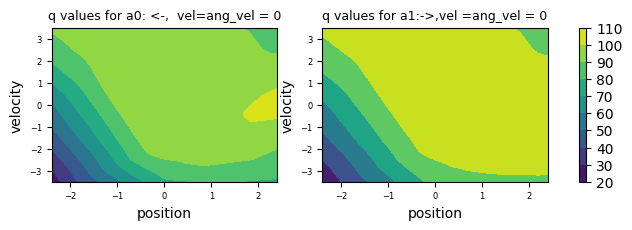

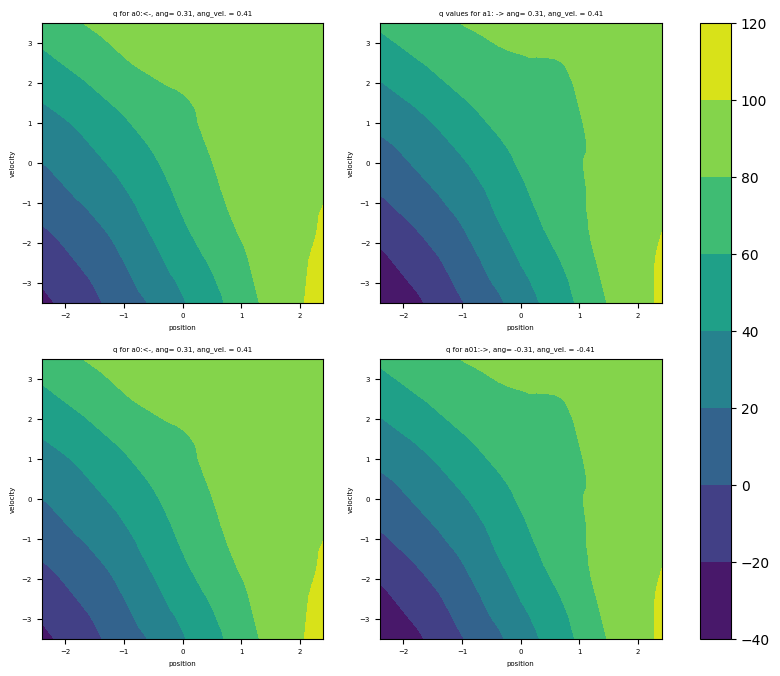

In [15]:
const_state_dic = { 'ang': 0, 'a_vel':0 }
x, y,q_a0, q_a1= Q_variable(dqn_agent, 100, 'pos', 'vel', const_state_dic)
def my_plotter(ax, data1, data2, data3):
    Q = ax.contourf(data1,data2, data3)
    return Q
fig1,ax = plt.subplots(1, 2, figsize=(8,2))
(ax1, ax2)= ax
plot_ax1 = my_plotter(ax1, x,y,q_a0)
plot_ax2 = my_plotter(ax2, x,y,q_a1)

ax1.set_xlabel('position')
ax1.tick_params(labelsize=6)
ax2.tick_params(labelsize=6)
(ax1).set_ylabel('velocity')
ax1.set_title("q values for a0: <-,  vel=ang_vel = 0",fontsize=9)
ax2.set_title("q values for a1:->,vel =ang_vel = 0",fontsize=9)
ax2.set_xlabel('position')
(ax2).set_ylabel('velocity')

cbar = plt.colorbar(plot_ax1, ax = ax)
const_state_dic1 = {'ang': 0.15, 'a_vel': 2.2 }
const_state_dic2 = {'ang': -0.15, 'a_vel': -2.2 }
x, y, q1_a0, q1_a1= Q_variable(dqn_agent, 100, 'pos', 'vel', const_state_dic1)
x, y, q1_a0, q1_a1= Q_variable(dqn_agent, 100, 'pos', 'vel', const_state_dic2)


fig2,ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8) )
(ax1, ax2), (ax3, ax4)= ax
plot_ax1 = my_plotter(ax1, x,y,q1_a0)
plot_ax2 = my_plotter(ax2, x,y,q1_a1)
plot_ax3 = my_plotter(ax3, x,y,q1_a0)
plot_ax4 = my_plotter(ax4, x,y,q1_a1)
ax1.tick_params(labelsize=5)

ax1.set_xlabel('position',fontsize=5)
(ax1).set_ylabel('velocity',fontsize=5)
ax1.set_title("q for a0:<-, ang= 0.31, ang_vel. = 0.41",fontsize=5)
ax2.set_title("q values for a1: -> ang= 0.31, ang_vel. = 0.41",fontsize=5)
ax2.tick_params(labelsize=5)
ax2.set_xlabel('position',fontsize=5)
(ax2).set_ylabel('velocity',fontsize=5)
ax3.set_xlabel('position',fontsize=5)
ax3.tick_params(labelsize=5)
(ax3).set_ylabel('velocity',fontsize=5)
ax3.set_title("q for a0:<-, ang= 0.31, ang_vel. = 0.41",fontsize=5)
ax4.set_title("q for a01:->, ang= -0.31, ang_vel. = -0.41",fontsize=5)
ax4.set_xlabel('position',fontsize=5)
(ax4).set_ylabel('velocity',fontsize=5)
ax4.tick_params(labelsize=5)

#ax1.clabel(CS, inline=True, inline_spacing=3, rightside_up=True )

cbar = plt.colorbar(plot_ax1, ax = ax)


first figure: 
it is clear from the 

## plopt Q values for varying pole angle and velocity

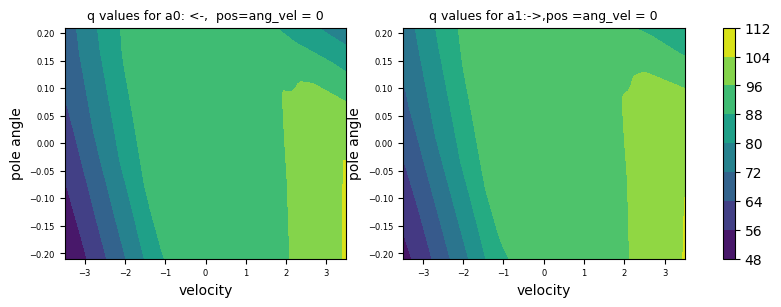

In [9]:
const_state_dic = { 'pos': 0, 'a_vel': 0 }
x, y,q_a0, q_a1= Q_variable(dqn_agent, 100, 'vel', 'ang', const_state_dic)
def my_plotter(ax, data1, data2, data3):
    Q = ax.contourf(data1,data2, data3)
    return Q
fig1,ax = plt.subplots(1, 2, figsize=(10,3))
(ax1, ax2)= ax
plot_ax1 = my_plotter(ax1, x,y,q_a0)
plot_ax2 = my_plotter(ax2, x,y,q_a1)
ax1.set_xlabel('velocity')
ax1.tick_params(labelsize=6)
ax2.tick_params(labelsize=6)
(ax1).set_ylabel('pole angle')
ax1.set_title("q values for a0: <-,  pos=ang_vel = 0",fontsize=9)
ax2.set_title("q values for a1:->,pos =ang_vel = 0",fontsize=9)
ax2.set_xlabel('velocity')
(ax2).set_ylabel('pole angle')
cbar = plt.colorbar(plot_ax1, ax = ax)

## plotting policy 

In [40]:
def policy(dqn_agent,data_len, xstate, ystate, const_state_dic):
    # move to the right
    span = {'pos': 2.4, 'vel': 3.5, 'ang': 0.2095, 'a_vel': 3.4}
    state_dic = {'pos': 0, 'vel': 0, 'ang':0 , 'a_vel': 0}
    for key in const_state_dic.keys():
        state_dic[key] = const_state_dic[key]
    policy=np.zeros((data_len,data_len))
    x_range = span[xstate]
    y_range = span[ystate]
    x = np.linspace(-x_range,x_range, data_len)
    y = np.linspace(-y_range, y_range, data_len)
    for i in range(data_len):
        for j in range(data_len):
            state_dic[xstate] = x[i]
            state_dic[ystate] = y[j]
            pos, vel, ang, a_vel = [state_dic[key] for key in state_dic.keys()]
            state = np.array([pos, vel, ang, a_vel])
            state = torch.tensor((state), requires_grad = False)
            state = state.to(dqn_agent.nn.adv.weight.dtype)
            Q_tensor = dqn_agent.nn(state)
            q_array = Q_tensor.detach().numpy()
            policy[j][i] = max(q_array)
            
        
    return x, y,policy




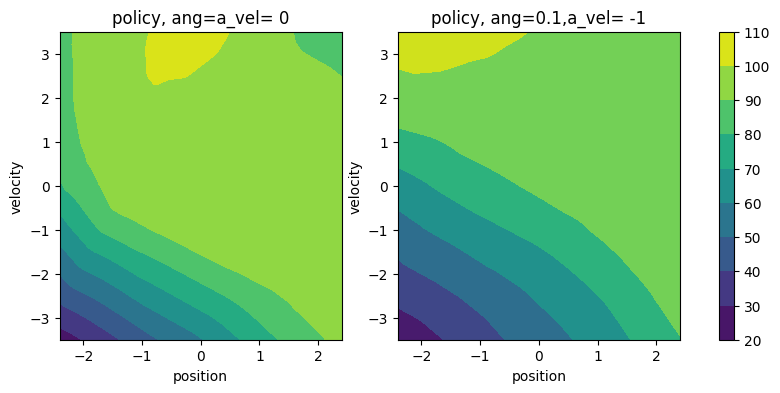

In [45]:

const_state_dic1= {'ang':0,'a_vel':0 }
x,y , policy1 = policy(dqn_agent, 100, 'pos', 'vel', const_state_dic1)
const_state_dic2= {'ang': -0.15,'a_vel':-1.5 }
x,y,policy2 = policy(dqn_agent, 100, 'pos', 'vel', const_state_dic2)

fig1,ax = plt.subplots(1,2, figsize=(10,4))
(ax1, ax2) = ax

plot_ax1 = ax1.contourf(x,y,policy1)
ax1.set_xlabel('position')
ax1.set_ylabel( 'velocity')
ax1.set_title('policy, ang=a_vel= 0')
plot_ax2 = ax2.contourf(x,y,policy2)
ax2.set_xlabel('position')
ax2.set_ylabel( 'velocity')
ax2.set_title('policy, ang=-0.15,a_vel= -1.5')

cbar = plt.colorbar(plot_ax1, ax = ax)


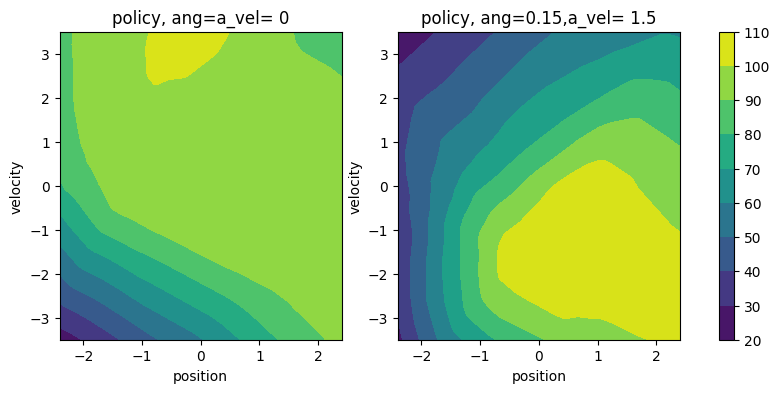

In [50]:
const_state_dic1= {'ang':0,'a_vel':0 }
x,y , policy1 = policy(dqn_agent, 100, 'pos', 'vel', const_state_dic1)
const_state_dic2= {'ang': 0.15,'a_vel':1.5 }
x,y,policy2 = policy(dqn_agent, 100, 'pos', 'vel', const_state_dic2)

fig1,ax = plt.subplots(1,2, figsize=(10,4))
(ax1, ax2) = ax

plot_ax1 = ax1.contourf(x,y,policy1)
ax1.set_xlabel('position')
ax1.set_ylabel( 'velocity')
ax1.set_title('policy, ang=a_vel= 0')
plot_ax2 = ax2.contourf(x,y,policy2)
ax2.set_xlabel('position')
ax2.set_ylabel( 'velocity')
ax2.set_title('policy, ang=0.15,a_vel= 1.5')

cbar = plt.colorbar(plot_ax1, ax = ax)


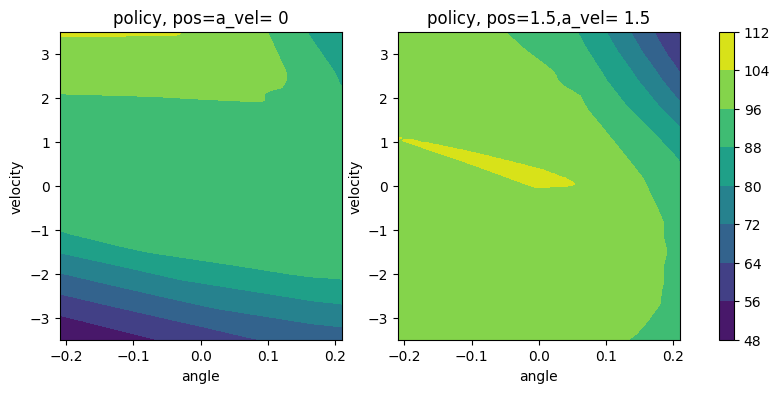

In [51]:
const_state_dic1= {'pos':0,'a_vel':0 }
x,y , policy1 = policy(dqn_agent, 100, 'ang', 'vel', const_state_dic1)
const_state_dic2= {'pos': 1.5,'a_vel':1.5 }
x,y,policy2 = policy(dqn_agent, 100, 'ang', 'vel', const_state_dic2)

fig1,ax = plt.subplots(1,2, figsize=(10,4))
(ax1, ax2) = ax

plot_ax1 = ax1.contourf(x,y,policy1)
ax1.set_xlabel('angle')
ax1.set_ylabel( 'velocity')
ax1.set_title('policy, pos=a_vel= 0')
plot_ax2 = ax2.contourf(x,y,policy2)
ax2.set_xlabel('angle')
ax2.set_ylabel( 'velocity')
ax2.set_title('policy, pos=1.5,a_vel= 1.5')

cbar = plt.colorbar(plot_ax1, ax = ax)


in the rightmost graph you can see that having a low positive velocity and a negative angle is best when angular velocity is 1.5 and position slightly to the right. this makes sence for counteracting the angular velocity. 

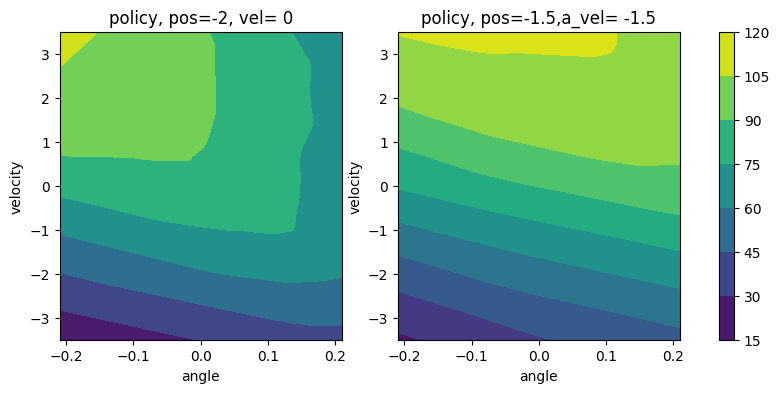

In [52]:
const_state_dic1= {'pos':-2,'a_vel':0 }
x,y , policy1 = policy(dqn_agent, 100, 'ang', 'vel', const_state_dic1)
const_state_dic2= {'pos': -1.5,'a_vel':-1.5 }
x,y,policy2 = policy(dqn_agent, 100, 'ang', 'vel', const_state_dic2)

fig1,ax = plt.subplots(1,2, figsize=(10,4))
(ax1, ax2) = ax

plot_ax1 = ax1.contourf(x,y,policy1)
ax1.set_xlabel('angle')
ax1.set_ylabel( 'velocity')
ax1.set_title('policy, pos=-2, vel= 0')
plot_ax2 = ax2.contourf(x,y,policy2)
ax2.set_xlabel('angle')
ax2.set_ylabel( 'velocity')
ax2.set_title('policy, pos=-1.5,a_vel= -1.5')

cbar = plt.colorbar(plot_ax1, ax = ax)
